# LAB: Árboles de clasificación para la predicción de enfermedades de corazón

## 1. Introducción

En esta LAB vamos a tratar de construir un modelo para predecir la presencia de un ataque cardíaco. Para ello usaremos el dataset `Heart.csv`. Estos datos contienen un resultado binario HD para 303 pacientes que se presentaron con dolor en el pecho. 

Un valor de resultado de Sí indica la presencia de una enfermedad cardíaca basada en una prueba angiográfica, mientras que No significa ninguna enfermedad cardíaca. Hay 13 predictores incluida la edad, el sexo, el colesterol (una medida del colesterol) y otros tipos de corazón y mediciones de la función pulmonar. 

## 2. Ejercicio

### Requisitos

1. Construir un árbol de clasificaciṕon
- Construir un árbol de clasificación con scikit-learn
    - Parámetros globales
    - Importancia de los atributos
    - Visualización de árboles
    - Usar GridSearchCV para encontrar el mejor árbol

**Extra:**

- Visualizar un árbol más complejo e interpretarlo

In [1]:
# Leer los datos con Pandas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
heart = pd.read_csv('Heart.csv')
heart.fillna('mean', inplace=True)

In [3]:
heart.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

* Recuerden que deberán lidiar con los $NA's$ y con los atributos categoŕicos. Pueden transformarlos en dummies para pasarlos como predictores en el árbol.

In [4]:
X = heart.drop('AHD', axis=1)

In [5]:
dumm = pd.get_dummies(X[list(X.columns[X.dtypes == 'object'])],drop_first=False)

In [6]:
# Concatenamos las dummies con las cuantitativas
X = pd.concat([X[list(heart.columns[heart.dtypes != 'object'])],dumm], axis=1)
atributos = X.columns

# Transformamos el target en 0 - 1
y = pd.get_dummies(heart.AHD, drop_first=True)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state= 1)


treeclf = DecisionTreeClassifier(max_depth=3, criterion='gini')
treeclf.fit(X, y)

print('CV_Score: ', np.mean(cross_val_score(treeclf, X, y, cv=kf)))

CV_Score:  0.752361353782


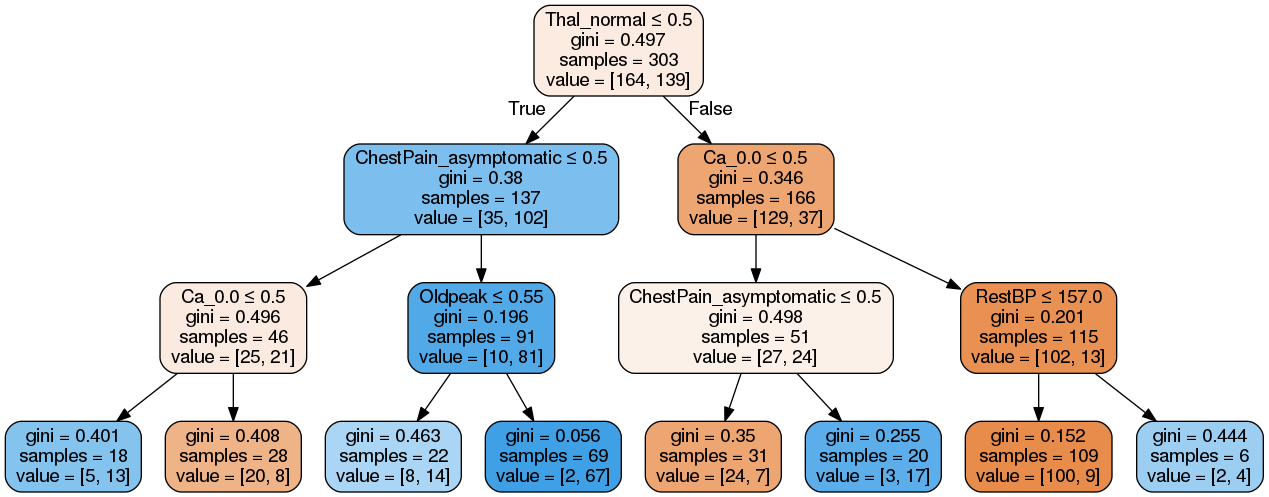

In [8]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [9]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
21,Thal_normal,0.494305
10,ChestPain_asymptomatic,0.253671
14,Ca_0.0,0.159848
2,RestBP,0.046960
8,Oldpeak,0.045216


* Seguramente deben estar viendo que el árbol tiene una performance... moderarada. Tratar de tunear los hiperparámetros con GridSearch para mejorar su performance.

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state= 1)



PARAMETROS = {#'max_features' : [1, 5, 10, 15, 20],
              'max_depth': [1,2,3,4,5,6,7], 
              'max_leaf_nodes' : [5,10,15,20,30], 
              'min_samples_leaf' : [1,2,3,4,5,10,15,20],
              'min_samples_split' : [5,6,7,8,9,10,20]}

#Se hace la búsqueda con Grid Search
model = DecisionTreeClassifier()
gs = GridSearchCV(model, PARAMETROS, scoring='accuracy', cv=kf, verbose=1 , n_jobs=-1)
gs.fit(X, y)

Fitting 3 folds for each of 1960 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 5528 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:   11.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7], 'max_leaf_nodes': [5, 10, 15, 20, 30], 'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15, 20], 'min_samples_split': [5, 6, 7, 8, 9, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [19]:
gs.best_score_

0.78217821782178221

In [20]:
tree_cv = gs.best_estimator_
tree_cv.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

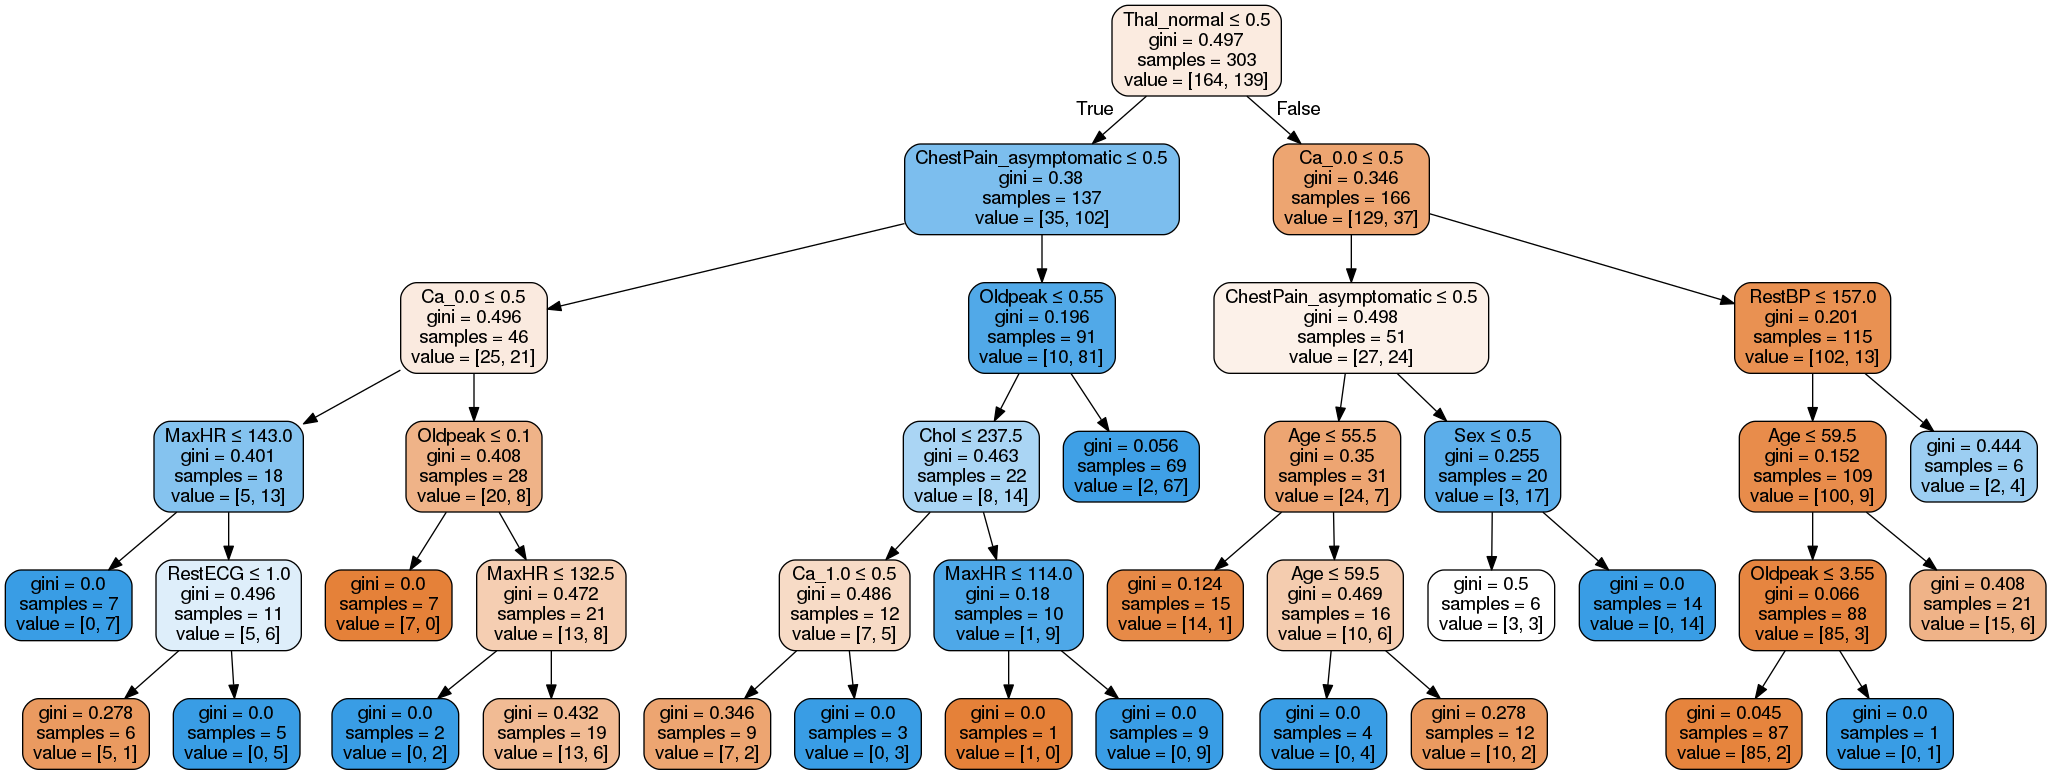

In [21]:
dot_data = export_graphviz(tree_cv, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())